/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-1-364554663ce6>:82: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


Found 410 validated image filenames belonging to 5 classes.
Found 137 validated image filenames belonging to 5 classes.
Found 137 validated image filenames belonging to 5 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.2380 - loss: 2.3269 - val_accuracy: 0.2190 - val_loss: 1.8088 - learning_rate: 1.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 524ms/step - accuracy: 0.3688 - loss: 2.3827 - val_accuracy: 0.1898 - val_loss: 1.8066 - learning_rate: 1.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 519ms/step - accuracy: 0.3329 - loss: 2.2709 - val_accuracy: 0.3285 - val_loss: 1.7836 - learning_rate: 1.0000e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step - accuracy: 0.3714 - loss: 1.9766 - val_accuracy: 0.1898 - val_loss: 1.9161 - learning_rate: 1.0000e-04
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step - accuracy: 0.3840 - loss: 2.0718 - val_accuracy: 0.4672 - val_loss: 1.6364 - learning_rate: 1.0000e-04
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - accuracy: 0.4480 - loss: 1.8355 - val_accuracy: 0.1971 - val_loss: 1.8930 - learning_rate: 1.0000e-04
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.4560 - los

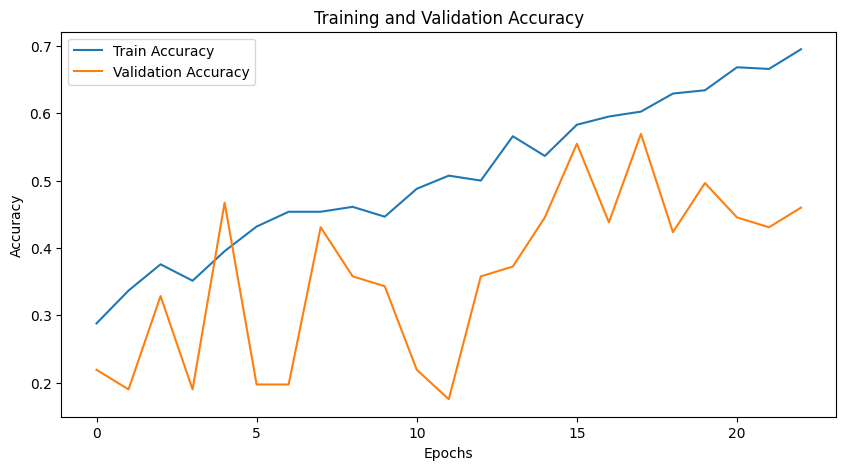

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


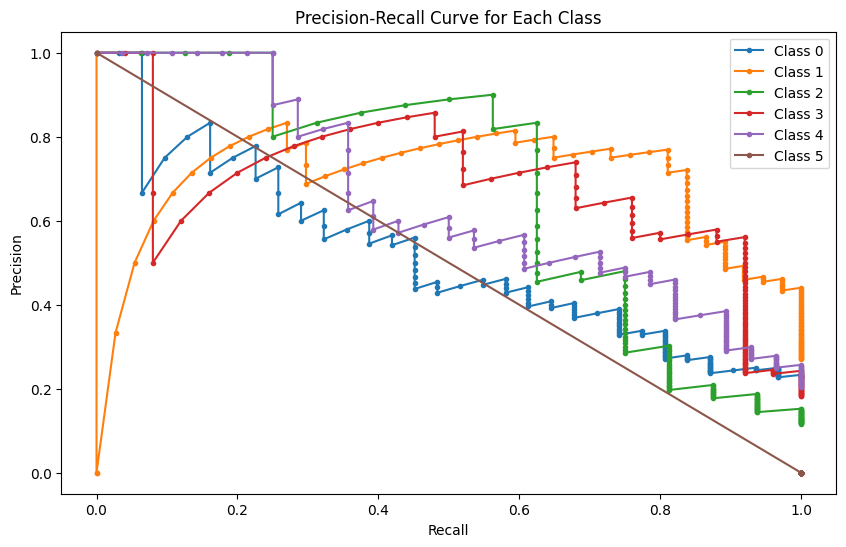

In [1]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.optimizers import Adam
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose, 
                                     concatenate, Dense, Flatten, Dropout, BatchNormalization, 
                                     GlobalAveragePooling2D)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import precision_recall_curve

# Define U-Net architecture 
def unet_classifier(input_shape=(224, 224, 3), num_classes=6):
    inputs = Input(input_shape)

    # Encoder (Downsampling)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Fully connected classification head
    x = Flatten()(c5)  # Convert feature maps to a single vector
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=out)
    return model



# dataset paths
dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
output_path = "/kaggle/working/expanded_dataset"
final_dataset_path = "/kaggle/working/final_processed_dataset"

# Ensure only valid labels are considered
valid_labels = {"BLB", "Blast", "healthy", "hispa", "leaf folder", "leaf spot"}

# Create necessary directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.RandomResizedCrop(height=200, width=200, scale=(0.7, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

# Expand dataset to 220 images per label
for label in os.listdir(dataset_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(dataset_path, label)
    save_path = os.path.join(output_path, label)
    os.makedirs(save_path, exist_ok=True)
    
    images = [os.path.join(label_path, img) for img in os.listdir(label_path)]
    
    while len(images) < 220:
        img_path = random.choice(images)
        img = cv2.imread(img_path)
        augmented = augmentations(image=img)["image"]
        cv2.imwrite(os.path.join(save_path, f"aug_{len(images)}.jpg"), augmented)
        images.append(img_path)

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {label: idx for idx, label in enumerate(valid_labels)}

for label in valid_labels:
    label_path = os.path.join(output_path, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_dataframe(pd.DataFrame({"filename": train_imgs, "class": train_labels}), x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
val_gen = datagen.flow_from_dataframe(pd.DataFrame({"filename": val_imgs, "class": val_labels}), x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
test_gen = datagen.flow_from_dataframe(pd.DataFrame({"filename": test_imgs, "class": test_labels}), x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False)

# Create U-Net classifier
model = unet_classifier()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Remove momentum
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler & early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=30, class_weight=class_weight_dict, 
                    callbacks=[lr_scheduler, early_stopping])

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print("Final Test Accuracy:", test_accuracy)

# Plot training/validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Compute and plot PR curve
num_classes = len(valid_labels)
y_true = tf.keras.utils.to_categorical(test_gen.classes, num_classes)
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()


Final Accuracy 
54%